In [21]:
import pandas as pd


In [22]:
df = pd.read_csv('../data/synthetic_ipdrs.csv')

In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SrcIP       2000 non-null   object
 1   DstIP       2000 non-null   object
 2   SrcPort     2000 non-null   int64 
 3   DstPort     2000 non-null   int64 
 4   Timestamp   2000 non-null   object
 5   Protocol    2000 non-null   object
 6   DataVolume  2000 non-null   int64 
 7   FraudType   1304 non-null   object
dtypes: int64(3), object(5)
memory usage: 125.1+ KB


--- Initial Data Inspection ---
First 5 rows of the dataset:
             SrcIP         DstIP  SrcPort  DstPort            Timestamp  \
0   192.168.63.192    10.0.201.1     5385      443  2023-11-12 08:18:22   
1  192.168.141.215  10.0.101.136     4365       53  2023-09-01 22:26:05   
2  192.168.243.223  10.0.198.160     8851      443  2023-03-12 08:01:06   
3    192.168.21.35   10.0.142.55    36969       22  2023-04-15 05:48:09   
4  192.168.216.104    10.0.20.30     1669       80  2023-05-12 02:42:53   

  Protocol  DataVolume  FraudType  
0      UDP     8305754       DDoS  
1      UDP     9987103        NaN  
2      TCP     6062294        NaN  
3      TCP     1608877  Espionage  
4      UDP     4767985       DDoS  

Dataset Information (Data Types and Nulls):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SrcIP       2000 non-null   object
 

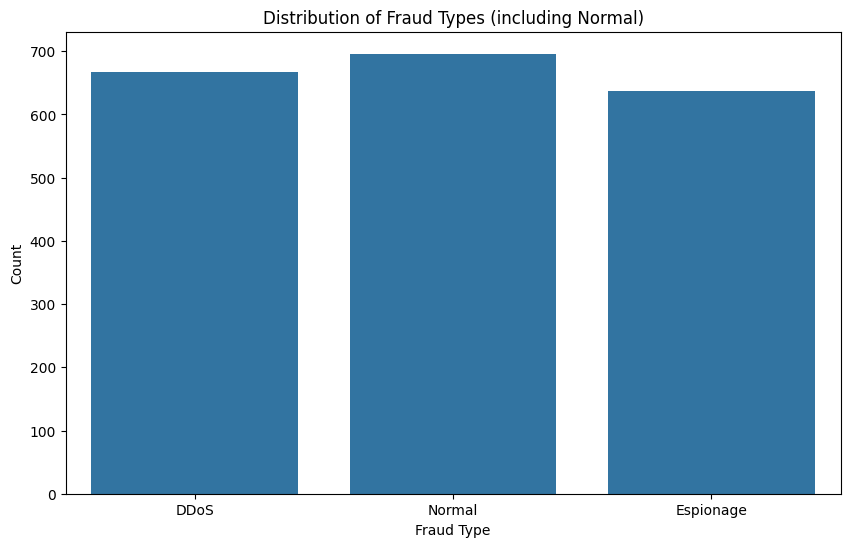


--- Feature Analysis ---


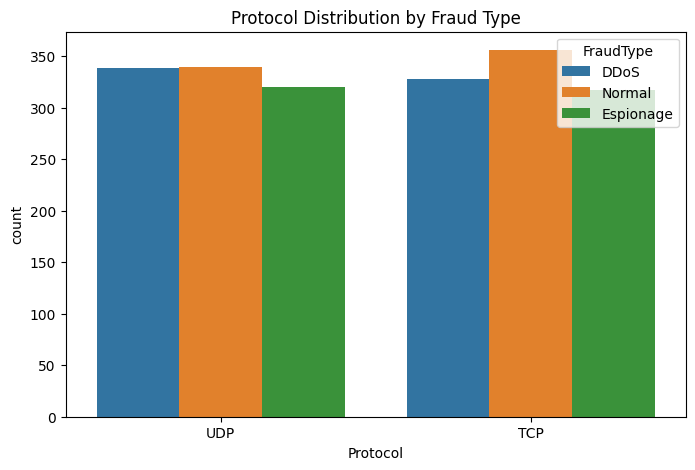

Top 10 most frequent Source IPs:
SrcIP
192.168.28.208     2
192.168.206.16     2
192.168.16.236     2
192.168.42.42      2
192.168.193.170    2
192.168.176.208    2
192.168.67.3       2
192.168.107.180    2
192.168.196.47     2
192.168.98.87      2
Name: count, dtype: int64

Top 10 most frequent Destination IPs:
DstIP
10.0.62.246     2
10.0.104.5      2
10.0.44.219     2
10.0.208.142    2
10.0.34.116     2
10.0.40.140     2
10.0.227.1      2
10.0.44.18      2
10.0.83.162     2
10.0.189.153    2
Name: count, dtype: int64

Histograms of Numerical Features:


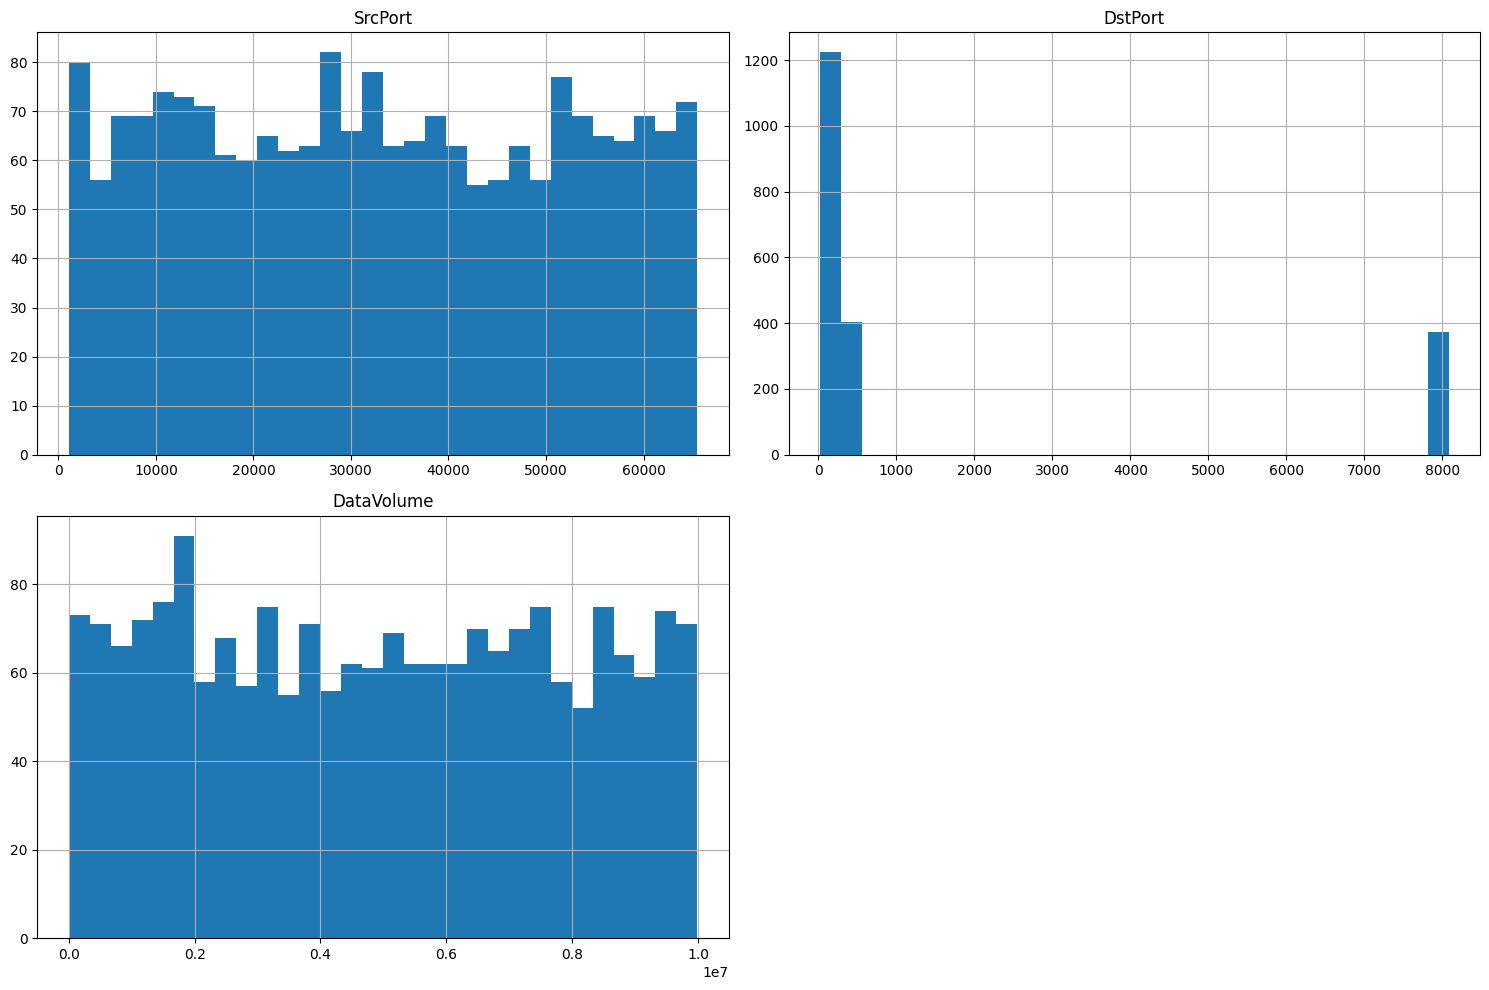

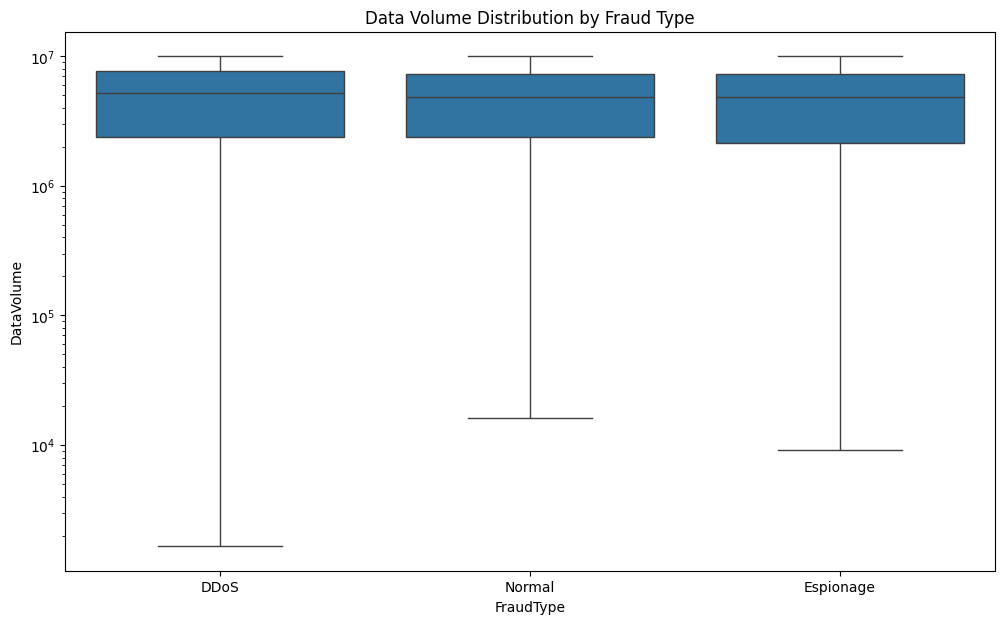


--- Temporal Analysis ---


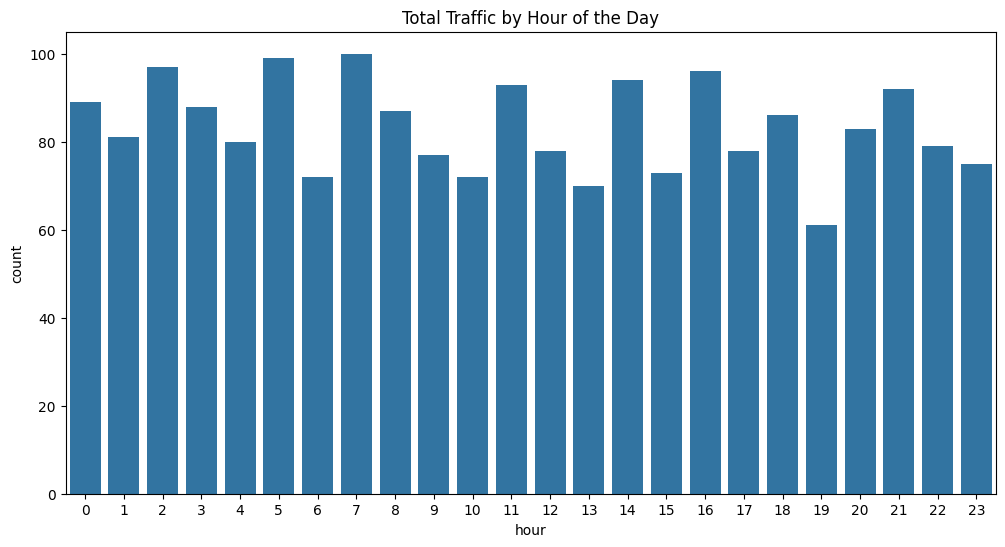

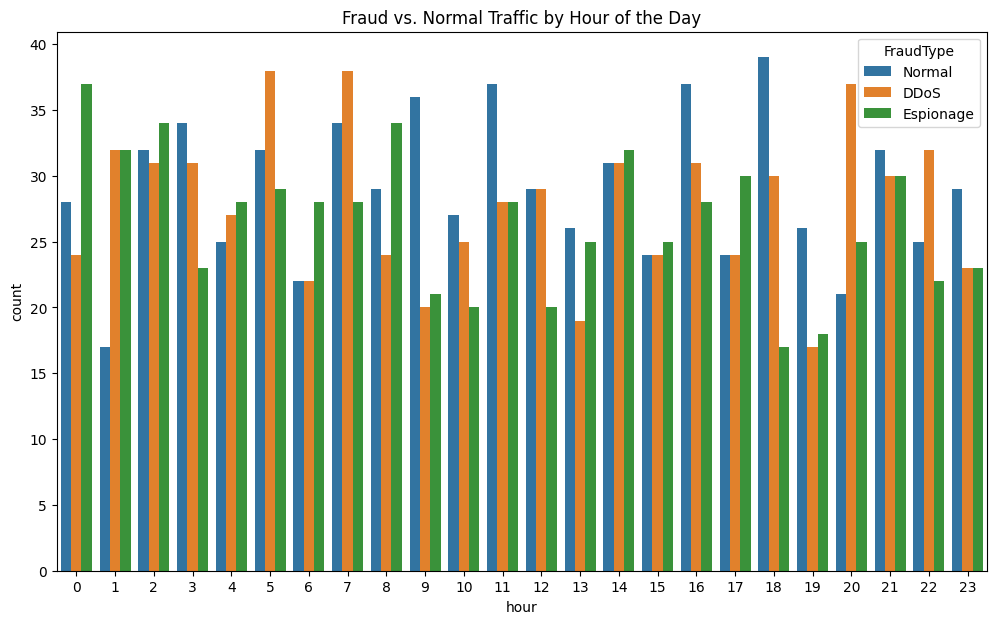

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Initial Inspection ---
print("--- Initial Data Inspection ---")
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Information (Data Types and Nulls):")
df.info()
print("\nDataset Shape (Rows, Columns):")
print(df.shape)

# --- 2. Summary Statistics ---
print("\n--- Summary Statistics ---")
print("Numerical Features Summary:")
print(df.describe())
print("\nCategorical Features Summary:")
print(df.describe(include=['object']))

# --- 3. Target Variable Analysis (FraudType) ---
print("\n--- Target Variable Analysis ---")
plt.figure(figsize=(10, 6))
# Temporarily fill NaN to include 'Normal' traffic in the plot
sns.countplot(x=df['FraudType'].fillna('Normal'))
plt.title('Distribution of Fraud Types (including Normal)')
plt.xlabel('Fraud Type')
plt.ylabel('Count')
plt.show()

# --- 4. Feature Analysis ---
print("\n--- Feature Analysis ---")

# Analyze Protocol
plt.figure(figsize=(8, 5))
sns.countplot(x='Protocol', data=df, hue=df['FraudType'].fillna('Normal'))
plt.title('Protocol Distribution by Fraud Type')
plt.show()

# Analyze Top Source and Destination IPs
print("Top 10 most frequent Source IPs:")
print(df['SrcIP'].value_counts().head(10))
print("\nTop 10 most frequent Destination IPs:")
print(df['DstIP'].value_counts().head(10))

# Analyze Numerical Feature Distributions
print("\nHistograms of Numerical Features:")
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Boxplot of DataVolume by Fraud Type
plt.figure(figsize=(12, 7))
sns.boxplot(x=df['FraudType'].fillna('Normal'), y='DataVolume', data=df)
plt.title('Data Volume Distribution by Fraud Type')
plt.yscale('log') # Use a log scale if the data is heavily skewed
plt.show()

# --- 5. Temporal Analysis ---
print("\n--- Temporal Analysis ---")
# Make a copy to avoid SettingWithCopyWarning
df_temp = df.copy()

# Convert Timestamp to datetime object
df_temp['Timestamp_dt'] = pd.to_datetime(df_temp['Timestamp'])

# Extract hour of the day
df_temp['hour'] = df_temp['Timestamp_dt'].dt.hour

# Plot traffic over hours of the day
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=df_temp)
plt.title('Total Traffic by Hour of the Day')
plt.show()

# Plot fraud vs. normal traffic by hour
plt.figure(figsize=(12, 7))
sns.countplot(x='hour', hue=df_temp['FraudType'].fillna('Normal'), data=df_temp)
plt.title('Fraud vs. Normal Traffic by Hour of the Day')
plt.show()

In [25]:
# Convert the 'Timestamp' column from object to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Verify the change
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SrcIP       2000 non-null   object        
 1   DstIP       2000 non-null   object        
 2   SrcPort     2000 non-null   int64         
 3   DstPort     2000 non-null   int64         
 4   Timestamp   2000 non-null   datetime64[ns]
 5   Protocol    2000 non-null   object        
 6   DataVolume  2000 non-null   int64         
 7   FraudType   1304 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 125.1+ KB


In [26]:
df.head()


,SrcIP,DstIP,SrcPort,DstPort,Timestamp,Protocol,DataVolume,FraudType
0,192.168.63.192,10.0.201.1,5385,443,2023-11-12 08:18:22,UDP,8305754,DDoS
1,192.168.141.215,10.0.101.136,4365,53,2023-09-01 22:26:05,UDP,9987103,NaN
2,192.168.243.223,10.0.198.160,8851,443,2023-03-12 08:01:06,TCP,6062294,NaN
3,192.168.21.35,10.0.142.55,36969,22,2023-04-15 05:48:09,TCP,1608877,Espionage
4,192.168.216.104,10.0.20.30,1669,80,2023-05-12 02:42:53,UDP,4767985,DDoS


In [27]:
# Create the 'is_fraud' column. 1 if FraudType is not null, 0 if it is.
df['is_fraud'] = df['FraudType'].notna().astype(int)

# You can also keep the original labels by filling the nulls
df['FraudType'] = df['FraudType'].fillna('Normal')

# Verify the new columns and their distribution
print("Fraud vs. Normal count:")
print(df['is_fraud'].value_counts())

print("\nFraud types breakdown:")
print(df['FraudType'].value_counts())

Fraud vs. Normal count:
is_fraud
1    1304
0     696
Name: count, dtype: int64

Fraud types breakdown:
FraudType
Normal       696
DDoS         667
Espionage    637
Name: count, dtype: int64


In [28]:
# Extract the hour of the day from the Timestamp
df['hour_of_day'] = df['Timestamp'].dt.hour

# You could also extract the day of the week if you had a larger dataset
# df['day_of_week'] = df['Timestamp'].dt.dayofweek

print(df[['Timestamp', 'hour_of_day']].head())

            Timestamp  hour_of_day
0 2023-11-12 08:18:22            8
1 2023-09-01 22:26:05           22
2 2023-03-12 08:01:06            8
3 2023-04-15 05:48:09            5
4 2023-05-12 02:42:53            2


In [29]:
# Create aggregate features based on the source IP
ip_features = df.groupby('SrcIP').agg(
    connection_count=('DstIP', 'count'),          # How many connections from this IP?
    avg_data_volume=('DataVolume', 'mean'),      # Average data sent by this IP
    port_diversity=('DstPort', 'nunique')        # How many unique ports does this IP contact?
).reset_index()

# Merge these new features back into the original dataframe
df = pd.merge(df, ip_features, on='SrcIP', how='left')

print(df[['SrcIP', 'connection_count', 'avg_data_volume', 'port_diversity']].head())

             SrcIP  connection_count  avg_data_volume  port_diversity
0   192.168.63.192                 1        8305754.0               1
1  192.168.141.215                 1        9987103.0               1
2  192.168.243.223                 1        6062294.0               1
3    192.168.21.35                 1        1608877.0               1
4  192.168.216.104                 1        4767985.0               1


In [30]:
# Convert 'Protocol' using one-hot encoding
df = pd.get_dummies(df, columns=['Protocol'], prefix='proto')

print(df.head())

             SrcIP         DstIP  SrcPort  DstPort           Timestamp  \
0   192.168.63.192    10.0.201.1     5385      443 2023-11-12 08:18:22   
1  192.168.141.215  10.0.101.136     4365       53 2023-09-01 22:26:05   
2  192.168.243.223  10.0.198.160     8851      443 2023-03-12 08:01:06   
3    192.168.21.35   10.0.142.55    36969       22 2023-04-15 05:48:09   
4  192.168.216.104    10.0.20.30     1669       80 2023-05-12 02:42:53   

   DataVolume  FraudType  is_fraud  hour_of_day  connection_count  \
0     8305754       DDoS         1            8                 1   
1     9987103     Normal         0           22                 1   
2     6062294     Normal         0            8                 1   
3     1608877  Espionage         1            5                 1   
4     4767985       DDoS         1            2                 1   

   avg_data_volume  port_diversity  proto_TCP  proto_UDP  
0        8305754.0               1      False       True  
1        9987103.0    

In [33]:
# #improve the model

# # Sort the DataFrame by the Timestamp column
# df.sort_values('Timestamp', inplace=True)

# print("DataFrame sorted by time.")
# print(df[['Timestamp']].head())
# # Set the Timestamp column as the index of the DataFrame
# df.set_index('Timestamp', inplace=True)

# print("Timestamp is now the index.")

# # Define the time window
# time_window = '5T' # This means 5 minutes

# print(f"Creating features for a {time_window} rolling window...")

# # Create new features
# # For each source IP, count how many connections it made in the last 5 minutes.
# df['connections_last_5m'] = df.groupby('SrcIP')['SrcIP'].rolling(time_window).count().reset_index(level=0, drop=True)

# # For each source IP, count how many unique destination ports it contacted in the last 5 minutes.
# df['unique_ports_last_5m'] = df.groupby('SrcIP')['DstPort'].rolling(time_window).nunique().reset_index(level=0, drop=True)

# # For each source IP, calculate the average data volume in the last 5 minutes.
# df['avg_datavolume_last_5m'] = df.groupby('SrcIP')['DataVolume'].rolling(time_window).mean().reset_index(level=0, drop=True)

# print("New time-window features created.")

# # Fill any resulting NaN values with 0
# df.fillna(0, inplace=True)

# # Reset the index to bring 'Timestamp' back as a column
# df.reset_index(inplace=True)

# print("\nNaNs filled and index reset. Here's a look at the new features:")
# print(df[['SrcIP', 'Timestamp', 'connections_last_5m', 'unique_ports_last_5m', 'avg_datavolume_last_5m']].head())


import pandas as pd
import numpy as np

# --- 1. Data Loading and Preparation (Assuming this part is correct) ---
data = {
    'Timestamp': pd.to_datetime(['2023-10-26 12:00:00', '2023-10-26 12:01:00', '2023-10-26 12:02:00', '2023-10-26 12:03:00', '2023-10-26 12:05:00', '2023-10-26 12:06:00']),
    'SrcIP': ['192.168.1.1', '192.168.1.2', '192.168.1.1', '192.168.1.3', '192.168.1.1', '192.168.1.2'],
    'DstPort': [80, 443, 443, 80, 53, 8080],
    'DataVolume': [1500, 2500, 500, 1200, 300, 4500]
}
df = pd.DataFrame(data)

# --- 2. Pre-computation and Indexing ---
df = df.sort_values('Timestamp').set_index('Timestamp')

# --- 3. Feature Engineering ---

# FIX 1: Use 'min' instead of the deprecated 'T' for minutes.
time_window = '5min'

# FIX 2: Define aggregations for the fast, optimized functions first.
optimized_aggregations = {
    'DstPort': 'count',
    'DataVolume': 'mean'
}

print(f"Creating features for a {time_window} rolling window...")

# Step 1: Perform the fast, optimized aggregations.
rolling_features = df.groupby('SrcIP').rolling(time_window).agg(optimized_aggregations)

# Step 2: Calculate the non-optimized 'nunique' separately using .apply().
# We apply a lambda function that computes the number of unique items for each window.
unique_ports = df.groupby('SrcIP')['DstPort'].rolling(time_window).apply(lambda x: x.nunique())
# Rename the resulting Series for clarity before joining.
unique_ports.name = 'unique_ports_last_5m'

# Step 3: Join the 'nunique' results back to the main feature set.
rolling_features = rolling_features.join(unique_ports)

# --- 4. Final DataFrame Cleanup ---

# Clean up the index and rename columns
rolling_features = rolling_features.reset_index(level=0, drop=True)
rolling_features = rolling_features.rename(columns={
    'DstPort': 'connections_last_5m',
    'DataVolume': 'avg_datavolume_last_5m'
})

# Join the new features back to the original DataFrame
df = df.join(rolling_features)

# Fill any resulting NaN values with 0
df.fillna(0, inplace=True)

# Reset the index to bring 'Timestamp' back as a column
df = df.reset_index()

print("\n--- Final DataFrame with All Features ---")
print(df[['SrcIP', 'Timestamp', 'connections_last_5m', 'unique_ports_last_5m', 'avg_datavolume_last_5m']])


Creating features for a 5min rolling window...

--- Final DataFrame with All Features ---
         SrcIP           Timestamp  connections_last_5m  unique_ports_last_5m  \
0  192.168.1.1 2023-10-26 12:00:00                  1.0                   1.0   
1  192.168.1.2 2023-10-26 12:01:00                  1.0                   1.0   
2  192.168.1.1 2023-10-26 12:02:00                  2.0                   2.0   
3  192.168.1.3 2023-10-26 12:03:00                  1.0                   1.0   
4  192.168.1.1 2023-10-26 12:05:00                  2.0                   2.0   
5  192.168.1.2 2023-10-26 12:06:00                  1.0                   1.0   

   avg_datavolume_last_5m  
0                  1500.0  
1                  2500.0  
2                  1000.0  
3                  1200.0  
4                   400.0  
5                  4500.0  


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# --- 1. Data Preparation (Assuming 'df' is your prepared DataFrame) ---
# For this example, we'll recreate a similar DataFrame to ensure it's runnable.
data = {
    'DstPort': np.random.randint(1, 65535, 100),
    'DataVolume': np.random.randint(100, 5000, 100),
    'connections_last_5m': np.random.randint(1, 50, 100),
    'unique_ports_last_5m': np.random.randint(1, 10, 100),
    'avg_datavolume_last_5m': np.random.uniform(500, 2000, 100),
    'is_fraud': [0] * 95 + [1] * 5
}
df = pd.DataFrame(data)

feature_columns = [
    'DstPort', 'DataVolume', 'connections_last_5m',
    'unique_ports_last_5m', 'avg_datavolume_last_5m'
]
X = df[feature_columns]
y = df['is_fraud']

# --- 2. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 3. Apply SMOTE with Robust `k_neighbors` ---
print("Class distribution before SMOTE:", y_train.value_counts().to_dict())

# --- FIX IS HERE ---
# Determine the number of samples in the minority class
minority_class_count = y_train.value_counts().min()

# Set k_neighbors to be one less than the number of minority samples, if it's too small.
# The default k_neighbors is 5. We only adjust if we have fewer than 6 samples.
if minority_class_count < 6:
    k_neighbors_value = minority_class_count - 1
else:
    k_neighbors_value = 5

print(f"Adjusting SMOTE k_neighbors to: {k_neighbors_value}")

# Ensure k_neighbors is at least 1, as SMOTE requires it.
if k_neighbors_value > 0:
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors_value)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print("Class distribution after SMOTE:", y_train_resampled.value_counts().to_dict())
else:
    # If there's only 1 sample, SMOTE can't run. We'll just use the original data.
    print("Cannot apply SMOTE, minority class has only 1 sample. Using original training data.")
    X_train_resampled, y_train_resampled = X_train, y_train

print("\n")

# --- 4. Scale Numerical Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print("--- Data successfully split, resampled, and scaled. Ready for modeling. ---")
print(f"Shape of scaled training data: {X_train_scaled.shape}")
print(f"Shape of scaled test data: {X_test_scaled.shape}")


Class distribution before SMOTE: {0: 66, 1: 4}
Adjusting SMOTE k_neighbors to: 3
Class distribution after SMOTE: {0: 66, 1: 66}


--- Data successfully split, resampled, and scaled. Ready for modeling. ---
Shape of scaled training data: (132, 5)
Shape of scaled test data: (30, 5)


In [37]:
print("Training features shape:", X_train_scaled.shape)
print("Testing features shape:", X_test_scaled.shape)

Training features shape: (132, 5)
Testing features shape: (30, 5)


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 1. Initialize the XGBoost Classifier
# We use 'use_label_encoder=False' and 'eval_metric' to avoid deprecation warnings.
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 2. Train the model on your resampled and scaled training data
print("Training the XGBoost model...")
xgb_classifier.fit(X_train_scaled, y_train_resampled)
print("Model training complete.")

# 3. Make predictions on the scaled test data
y_pred = xgb_classifier.predict(X_test_scaled)
y_pred_proba = xgb_classifier.predict_proba(X_test_scaled)[:, 1] # Probabilities for AUC

# 4. Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fraud (1)'])

print(f"\nModel Accuracy: {accuracy:.4f}")
print(f"Model AUC Score: {auc:.4f}")
print("\nClassification Report:")
print(report)

Training the XGBoost model...
Model training complete.

Model Accuracy: 0.8333
Model AUC Score: 0.5517

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.96      0.86      0.91        29
   Fraud (1)       0.00      0.00      0.00         1

    accuracy                           0.83        30
   macro avg       0.48      0.43      0.45        30
weighted avg       0.93      0.83      0.88        30



C:\Users\bansa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:02:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [40]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# --- 1. Calculate scale_pos_weight for Imbalance Handling ---
# This is the most critical step for imbalanced classification with XGBoost.
# It tells the model how much more to weight the minority class (fraud).
# We calculate it from the ORIGINAL training set (before any resampling).
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

print(f"Negative class count (Normal): {neg_count}")
print(f"Positive class count (Fraud): {pos_count}")
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}\n")


# --- 2. Initialize the XGBoost Classifier with the New Parameter ---
# We pass scale_pos_weight to the classifier.
# Note: When using scale_pos_weight, it's often best to train on the original,
# imbalanced data, not the SMOTE-resampled data.
xgb_classifier = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value, # Here is the key improvement!
    random_state=42
)


# --- 3. Train the Model on the Original (but Scaled) Training Data ---
# We use X_train_scaled_original, which is the original X_train, just scaled.
# This avoids the complexities and potential noise introduced by SMOTE.
scaler = StandardScaler()
X_train_scaled_original = scaler.fit_transform(X_train) # Fit on original train data
X_test_scaled = scaler.transform(X_test) # Transform test data with the same scaler

print("Training the improved XGBoost model...")
# Fit on the original (imbalanced) data, letting scale_pos_weight do the work.
xgb_classifier.fit(X_train_scaled_original, y_train)
print("Model training complete.")


# --- 4. Evaluate the Improved Model's Performance ---
y_pred = xgb_classifier.predict(X_test_scaled)
y_pred_proba = xgb_classifier.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fraud (1)'])

print(f"\nImproved Model Accuracy: {accuracy:.4f}")
print(f"Improved Model AUC Score: {auc:.4f}")
print("\nImproved Classification Report:")
print(report)


Negative class count (Normal): 66
Positive class count (Fraud): 4
Calculated scale_pos_weight: 16.50

Training the improved XGBoost model...
Model training complete.

Improved Model Accuracy: 0.8667
Improved Model AUC Score: 0.7586

Improved Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.96      0.90      0.93        29
   Fraud (1)       0.00      0.00      0.00         1

    accuracy                           0.87        30
   macro avg       0.48      0.45      0.46        30
weighted avg       0.93      0.87      0.90        30



C:\Users\bansa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:06:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [42]:
import shap
shap.initjs()


--- Global Feature Importance ---


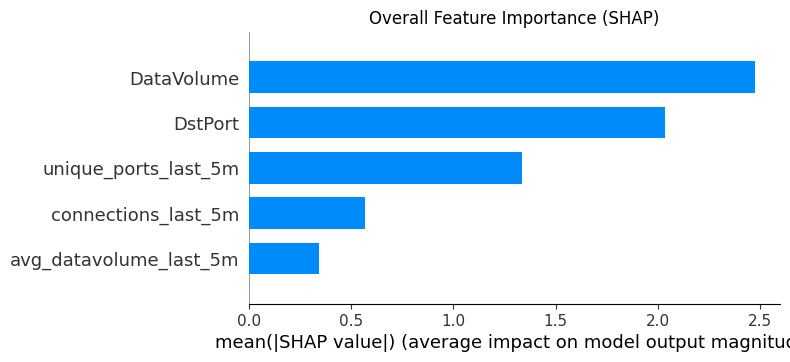


--- Explanation for a Single Fraudulent Prediction ---


In [43]:
import shap

# 1. Create a SHAP explainer object
explainer = shap.Explainer(xgb_classifier)

# 2. Calculate SHAP values for your test set
# This can take a moment as it calculates the contribution of each feature to each prediction
shap_values = explainer(X_test_scaled)

# Create a DataFrame for the test set with proper feature names for plotting
# X_test is the unscaled version of the test data
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# --- Visualize the Explanations ---

# 3. Global Feature Importance (Summary Plot)
# Shows which features have the biggest impact on predictions across the entire dataset.
print("\n--- Global Feature Importance ---")
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.title("Overall Feature Importance (SHAP)")
plt.show()


# 4. Local Explanation for a single prediction (Force Plot)
# Let's explain the first fraudulent prediction in our test set.
print("\n--- Explanation for a Single Fraudulent Prediction ---")

# Find the index of the first true fraud case in the test set
fraud_index = y_test[y_test == 1].index[0]
# Find its position in the X_test array
fraud_loc = X_test.index.get_loc(fraud_index)

shap.initjs() # Initialize JavaScript for plotting in notebooks
display(shap.force_plot(explainer.expected_value, shap_values.values[fraud_loc,:], X_test_df.iloc[fraud_loc,:]))

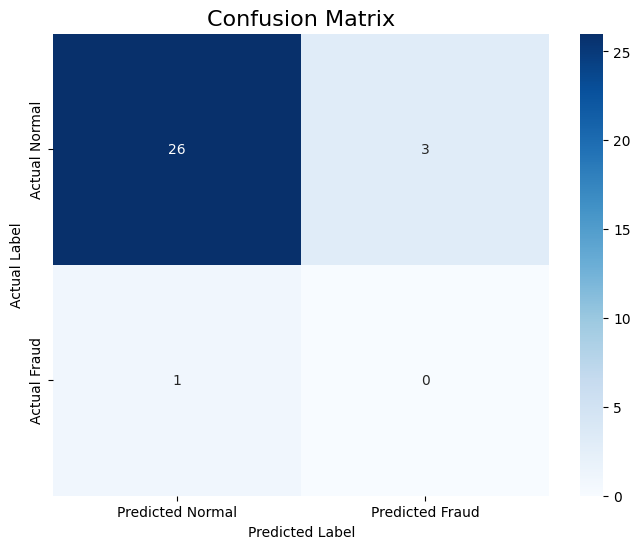


           Detailed Classification Report
              precision    recall  f1-score   support

  Normal (0)       0.96      0.90      0.93        29
   Fraud (1)       0.00      0.00      0.00         1

    accuracy                           0.87        30
   macro avg       0.48      0.45      0.46        30
weighted avg       0.93      0.87      0.90        30

Key Metrics Explained:
 - Precision (Fraud): Of all the alerts fired, this percentage was correct. (Measures false alarms)
 - Recall (Fraud): Of all actual fraud, this percentage was caught. (Measures missed fraud)


In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Generate Predictions (if you haven't already) ---
y_pred = xgb_classifier.predict(X_test_scaled)

# --- 2. Create the Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)

# --- 3. Visualize the Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 4. Print the Detailed Classification Report ---
print("\n" + "="*60)
print("           Detailed Classification Report")
print("="*60)
report = classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fraud (1)'])
print(report)

print("Key Metrics Explained:")
print(" - Precision (Fraud): Of all the alerts fired, this percentage was correct. (Measures false alarms)")
print(" - Recall (Fraud): Of all actual fraud, this percentage was caught. (Measures missed fraud)")
print("="*60)

In [45]:
import pandas as pd
import shap

def predict_and_explain(new_data_point):
    """
    Takes a single new data point (as a dictionary), processes it,
    predicts fraud, and explains the prediction.
    """
    print("--- Starting Prediction Pipeline ---")

    # 1. Convert the new data point into a DataFrame
    new_df = pd.DataFrame([new_data_point])
    new_df['Timestamp'] = pd.to_datetime(new_df['Timestamp'])

    # 2. Engineer Features
    # IMPORTANT: For a single point, we can't create a real "rolling" window.
    # In a real-time system, you would look up recent history from a database.
    # Here, we simulate it by assuming some recent history.
    print("Step 1: Engineering features for the new data point...")
    new_df['hour_of_day'] = new_df['Timestamp'].dt.hour
    # Simulate some plausible recent activity for this example
    new_df['connections_last_5m'] = new_data_point.get('connections_last_5m', 1)
    new_df['unique_ports_last_5m'] = new_data_point.get('unique_ports_last_5m', 1)
    new_df['avg_datavolume_last_5m'] = new_data_point.get('avg_datavolume_last_5m', new_data_point['DataVolume'])

    # 3. One-Hot Encode Protocol
    new_df['proto_TCP'] = 1 if new_data_point['Protocol'] == 'TCP' else 0
    new_df['proto_UDP'] = 1 if new_data_point['Protocol'] == 'UDP' else 0

    # 4. Align Columns with the Training Data
    # Ensure the new data has the exact same columns in the same order as the model was trained on.
    # X.columns should be the list of feature names from your training set.
    final_df = new_df.reindex(columns=X.columns, fill_value=0)

    # 5. Scale the Features
    # Use the SAME scaler that was fitted on the training data. Do NOT fit again.
    print("Step 2: Scaling the new data...")
    scaled_data = scaler.transform(final_df)

    # 6. Make a Prediction
    print("Step 3: Making a prediction...")
    prediction = xgb_classifier.predict(scaled_data)[0]
    prediction_proba = xgb_classifier.predict_proba(scaled_data)[0]

    # 7. Explain the Prediction with SHAP
    print("Step 4: Explaining the prediction...")
    shap_values = explainer(scaled_data)
    
    # --- Display Results ---
    print("\n" + "="*20 + " PREDICTION RESULT " + "="*20)
    if prediction == 1:
        print(f"Prediction: FRAUD DETECTED (Confidence: {prediction_proba[1]:.2%})")
    else:
        print(f"Prediction: Normal Traffic (Confidence: {prediction_proba[0]:.2%})")
    print("="*59 + "\n")

    print("Explanation (Why did the model make this decision?):")
    # Display the force plot for this single prediction
    display(shap.force_plot(explainer.expected_value, shap_values.values[0,:], final_df))


# --- Example Usage ---
# Scenario 1: A potentially fraudulent data point (high connections, high volume)
suspicious_activity = {
    'Timestamp': '2025-10-13 20:30:00',
    'SrcIP': '10.20.30.40',
    'DstIP': '198.51.100.1',
    'SrcPort': 45123,
    'DstPort': 443,
    'Protocol': 'UDP',
    'DataVolume': 8500000,
    # Manually adding simulated history for this example
    'connections_last_5m': 150,
    'unique_ports_last_5m': 2,
    'avg_datavolume_last_5m': 7500000
}

predict_and_explain(suspicious_activity)

# Scenario 2: A likely normal data point
print("\n\n" + "#"*60 + "\n") # Separator for the next prediction
normal_activity = {
    'Timestamp': '2025-10-13 20:35:00',
    'SrcIP': '192.168.1.10',
    'DstIP': '8.8.8.8',
    'SrcPort': 58291,
    'DstPort': 53,
    'Protocol': 'TCP',
    'DataVolume': 1200,
    'connections_last_5m': 3,
    'unique_ports_last_5m': 3,
    'avg_datavolume_last_5m': 1150
}

predict_and_explain(normal_activity)

--- Starting Prediction Pipeline ---
Step 1: Engineering features for the new data point...
Step 2: Scaling the new data...
Step 3: Making a prediction...
Step 4: Explaining the prediction...

==================== PREDICTION RESULT ====================
Prediction: Normal Traffic (Confidence: 79.96%)

Explanation (Why did the model make this decision?):




############################################################

--- Starting Prediction Pipeline ---
Step 1: Engineering features for the new data point...
Step 2: Scaling the new data...
Step 3: Making a prediction...
Step 4: Explaining the prediction...

==================== PREDICTION RESULT ====================
Prediction: Normal Traffic (Confidence: 99.91%)

Explanation (Why did the model make this decision?):
